In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/data.csv', encoding='latin1')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.shape

(541909, 8)

## Data Cleaning

In [7]:
# remove alphabets from the invoice column
df = df[~df['InvoiceNo'].str.contains('C', na=False)]

In [8]:
df = df.dropna(subset=['CustomerID'])

In [9]:
df = df[df['Quantity'] > 0]

In [10]:
df = df[df['UnitPrice'] > 0]

In [11]:
# Keep only numeric stock codes
df = df[df['StockCode'].str.isnumeric()]

In [12]:
df['StockCode'].unique()

array(['71053', '22752', '21730', ..., '23561', '90089', '23843'],
      shape=(2785,), dtype=object)

In [13]:
df = df.drop_duplicates()

In [14]:
# Remove rows with no description
df = df[df['Description'].notna()]

In [15]:
#datatime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [16]:
# Add Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [17]:
# Revenue per customer
revenue_per_customer = df.groupby('CustomerID')['TotalPrice'].sum().reset_index(name='Revenue')
revenue_per_customer

,CustomerID,Revenue
0,12346.0,77183.60
1,12347.0,3653.45
2,12348.0,1437.24
3,12349.0,1372.42
4,12350.0,258.00
...,...,...
4309,18280.0,180.60
4310,18281.0,80.82
4311,18282.0,178.05
4312,18283.0,1918.24


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358277 entries, 1 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    358277 non-null  object        
 1   StockCode    358277 non-null  object        
 2   Description  358277 non-null  object        
 3   Quantity     358277 non-null  int64         
 4   InvoiceDate  358277 non-null  datetime64[ns]
 5   UnitPrice    358277 non-null  float64       
 6   CustomerID   358277 non-null  float64       
 7   Country      358277 non-null  object        
 8   TotalPrice   358277 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 27.3+ MB


In [19]:
# df.isna().sum()

In [29]:
#save cleaned data
df.to_csv('data/cleaned_data.csv', index=False)

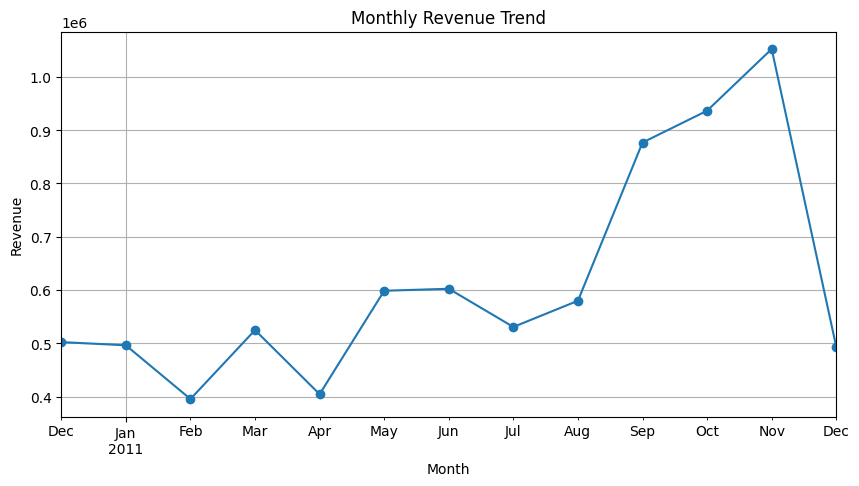

In [20]:
#Monthly revenue trend
monthly_revenue = df.groupby(df['InvoiceDate'].dt.to_period("M"))['TotalPrice'].sum()
monthly_revenue.index = monthly_revenue.index.to_timestamp()

plt.figure(figsize=(10,5))
monthly_revenue.plot(kind='line', marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

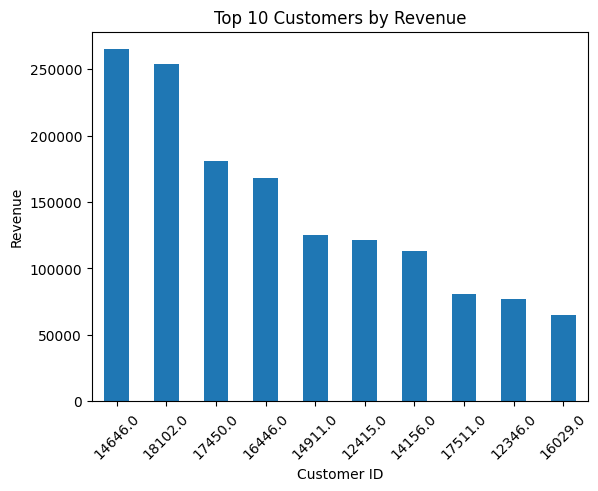

In [21]:
#top 10 customer based on revenue
top_customers = revenue_per_customer.sort_values(by='Revenue', ascending=False).head(10)
top_customers.plot(kind='bar', x='CustomerID', y='Revenue', legend=False)
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

In [22]:
#RFM Metrics after cleaning [Recency, Frequency, Monetary]
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,    
    'InvoiceNo': 'nunique',                                     
    'TotalPrice': 'sum'                                         
}).reset_index()
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

In [23]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,3653.45
2,12348.0,75,4,1437.24
3,12349.0,19,1,1372.42
4,12350.0,310,1,258.00


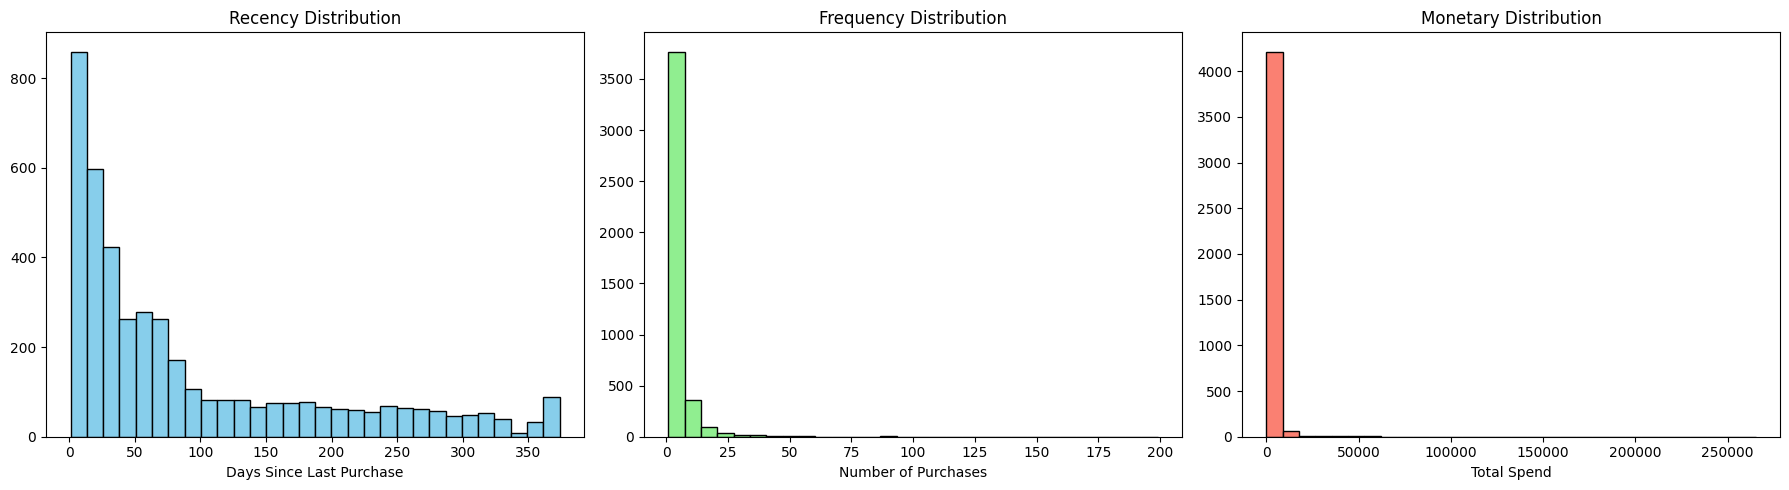

In [24]:
#Distribution of RFM metrics
fig, axes = plt.subplots(1, 3, figsize=(18,5))

axes[0].hist(rfm['Recency'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("Recency Distribution")
axes[0].set_xlabel("Days Since Last Purchase")

axes[1].hist(rfm['Frequency'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title("Frequency Distribution")
axes[1].set_xlabel("Number of Purchases")

axes[2].hist(rfm['Monetary'], bins=30, color='salmon', edgecolor='black')
axes[2].set_title("Monetary Distribution")
axes[2].set_xlabel("Total Spend")

plt.tight_layout()
plt.show()

RFM Distributions key insights:

    Recency: many customers haven’t purchased in a long time (potential churn).
    Frequency: most customers buy only a few times.
    Monetary: only a small group contributes high revenue.

## Data Engineering Workflows

In [25]:
import psycopg2
from sqlalchemy import create_engine
import os
from datetime import datetime

In [26]:
#database confriguartion
from dotenv import load_dotenv
import os

load_dotenv()

#confriguation
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'ecommerce_analytics'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD'), 
    'port': int(os.getenv('DB_PORT', 5432))
}

print("Environment variables check:")
print(f"DB_HOST: {DB_CONFIG['host']}")
print(f"DB_NAME: {DB_CONFIG['database']}")
print(f"DB_USER: {DB_CONFIG['user']}")
print(f"DB_PASSWORD: {'Loaded' if DB_CONFIG['password'] else ' NOT FOUND'}")
print(f"DB_PORT: {DB_CONFIG['port']}")

# Verify if password is loaded
if not DB_CONFIG['password']:
    print("ERROR: DB_PASSWORD not found in .env file!")
    print("Make sure your .env file contains: DB_PASSWORD=your_actual_password")
else:
    print("All configuration loaded successfully!")

Environment variables check:
DB_HOST: localhost
DB_NAME: ecommerce_analytics
DB_USER: postgres
DB_PASSWORD: Loaded
DB_PORT: 5432
All configuration loaded successfully!


In [27]:
def create_db_connection():
    """Create PostgreSQL database connection and SQLAlchemy engine"""
    
    # Check if password is loaded
    if not DB_CONFIG['password']:
        print("ERROR: Database password not found!")
        print("Check your .env file and make sure it contains DB_PASSWORD=your_password")
        return None, None
    
    try:
        print("Attempting to connect to PostgreSQL...")
        
        # SQLAlchemy engine for pandas integration
        engine = create_engine(f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}")
        
        # Direct psycopg2 connection for DDL operations
        conn = psycopg2.connect(**DB_CONFIG)
        
        # Test the connection
        cursor = conn.cursor()
        cursor.execute("SELECT version();")
        version = cursor.fetchone()[0]
        cursor.close()
        
        print("Successfully connected to PostgreSQL!")
        print(f"Database: {DB_CONFIG['database']}")
        print(f"PostgreSQL version: {version.split()[0]} {version.split()[1]}")
        return conn, engine
    
    except psycopg2.OperationalError as e:
        print(f"Connection failed: {e}")
        return None, None
    
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, None

conn, engine = create_db_connection()

Attempting to connect to PostgreSQL...
Successfully connected to PostgreSQL!
Database: ecommerce_analytics
PostgreSQL version: PostgreSQL 17.6


In [28]:
#database schema
def create_postgres_schema(conn):
    """Create PostgreSQL database schema with normalized tables and proper constraints"""
    
    cursor = conn.cursor()
    
    try:
        print("Creating PostgreSQL schema...")
        
        # Drop existing tables in correct order (reverse of creation due to foreign keys)
        cursor.execute('''
            DROP TABLE IF EXISTS order_items CASCADE;
            DROP TABLE IF EXISTS orders CASCADE;
            DROP TABLE IF EXISTS products CASCADE;
            DROP TABLE IF EXISTS customers CASCADE;
        ''')
        
        # 1. Customers dimension table
        cursor.execute('''
            CREATE TABLE customers (
                customer_id BIGINT PRIMARY KEY,
                first_purchase_date DATE NOT NULL,
                last_purchase_date DATE NOT NULL,
                total_orders INTEGER DEFAULT 0 CHECK (total_orders >= 0),
                total_spent DECIMAL(12,2) DEFAULT 0.00 CHECK (total_spent >= 0),
                avg_order_value DECIMAL(10,2),
                customer_segment VARCHAR(20),
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                CONSTRAINT chk_purchase_dates CHECK (last_purchase_date >= first_purchase_date)
            )
        ''')
        
        # 2. Products dimension table
        cursor.execute('''
            CREATE TABLE products (
                stock_code VARCHAR(50) PRIMARY KEY,
                description TEXT NOT NULL,
                unit_price DECIMAL(10,2) CHECK (unit_price >= 0),
                first_seen_date DATE,
                category VARCHAR(100),
                is_active BOOLEAN DEFAULT TRUE,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        
        # 3. Orders fact table
        cursor.execute('''
            CREATE TABLE orders (
                invoice_no VARCHAR(50) PRIMARY KEY,
                customer_id BIGINT NOT NULL,
                invoice_date DATE NOT NULL,
                country VARCHAR(100),
                total_amount DECIMAL(12,2) DEFAULT 0.00 CHECK (total_amount >= 0),
                total_items INTEGER DEFAULT 0 CHECK (total_items >= 0),
                order_status VARCHAR(20) DEFAULT 'completed',
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (customer_id) REFERENCES customers (customer_id) ON DELETE CASCADE
            )
        ''')
        
        # 4. Order items fact table
        cursor.execute('''
            CREATE TABLE order_items (
                id SERIAL PRIMARY KEY,
                invoice_no VARCHAR(50) NOT NULL,
                stock_code VARCHAR(50) NOT NULL,
                quantity INTEGER NOT NULL CHECK (quantity > 0),
                unit_price DECIMAL(10,2) NOT NULL CHECK (unit_price > 0),
                total_price DECIMAL(12,2) NOT NULL CHECK (total_price > 0),
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (invoice_no) REFERENCES orders (invoice_no) ON DELETE CASCADE,
                FOREIGN KEY (stock_code) REFERENCES products (stock_code) ON DELETE CASCADE
            )
        ''')
        
        # Create performance indexes
        cursor.execute('''
            CREATE INDEX idx_customers_total_spent ON customers (total_spent DESC);
            CREATE INDEX idx_customers_segment ON customers (customer_segment);
            CREATE INDEX idx_orders_customer_id ON orders (customer_id);
            CREATE INDEX idx_orders_invoice_date ON orders (invoice_date);
            CREATE INDEX idx_orders_country ON orders (country);
            CREATE INDEX idx_orders_total_amount ON orders (total_amount DESC);
            CREATE INDEX idx_order_items_invoice_no ON order_items (invoice_no);
            CREATE INDEX idx_order_items_stock_code ON order_items (stock_code);
            CREATE INDEX idx_order_items_total_price ON order_items (total_price DESC);
            CREATE INDEX idx_products_unit_price ON products (unit_price);
            CREATE INDEX idx_products_category ON products (category);
        ''')
        
        # Create business intelligence views
        cursor.execute('''
            CREATE OR REPLACE VIEW monthly_sales_summary AS
            SELECT 
                DATE_TRUNC('month', invoice_date) as sales_month,
                COUNT(DISTINCT invoice_no) as total_orders,
                COUNT(DISTINCT customer_id) as unique_customers,
                SUM(total_amount) as total_revenue,
                AVG(total_amount) as avg_order_value,
                MAX(total_amount) as max_order_value,
                MIN(total_amount) as min_order_value
            FROM orders 
            GROUP BY DATE_TRUNC('month', invoice_date)
            ORDER BY sales_month;
        ''')
        
        cursor.execute('''
            CREATE OR REPLACE VIEW customer_analytics AS
            SELECT 
                c.*,
                (CURRENT_DATE - c.last_purchase_date) as days_since_last_order,
                CASE 
                    WHEN c.total_spent >= 5000 THEN 'High Value'
                    WHEN c.total_spent >= 1000 THEN 'Medium Value' 
                    ELSE 'Low Value'
                END as value_segment,
                CASE 
                    WHEN (CURRENT_DATE - c.last_purchase_date) <= 30 THEN 'Active'
                    WHEN (CURRENT_DATE - c.last_purchase_date) <= 90 THEN 'At Risk'
                    ELSE 'Inactive'
                END as activity_status
            FROM customers c;
        ''')
        
        cursor.execute('''
            CREATE OR REPLACE VIEW product_performance AS
            SELECT 
                p.stock_code,
                p.description,
                p.unit_price,
                p.category,
                COUNT(oi.id) as times_ordered,
                SUM(oi.quantity) as total_quantity_sold,
                SUM(oi.total_price) as total_revenue,
                AVG(oi.unit_price) as avg_selling_price,
                COUNT(DISTINCT oi.invoice_no) as unique_orders
            FROM products p
            LEFT JOIN order_items oi ON p.stock_code = oi.stock_code
            GROUP BY p.stock_code, p.description, p.unit_price, p.category
            ORDER BY total_revenue DESC NULLS LAST;
        ''')
        
        # Create stored procedures for common operations
        cursor.execute('''
            CREATE OR REPLACE FUNCTION update_customer_stats()
            RETURNS TRIGGER AS $$
            BEGIN
                UPDATE customers SET 
                    updated_at = CURRENT_TIMESTAMP,
                    total_orders = (
                        SELECT COUNT(*) FROM orders WHERE customer_id = NEW.customer_id
                    ),
                    total_spent = (
                        SELECT COALESCE(SUM(total_amount), 0) FROM orders WHERE customer_id = NEW.customer_id
                    ),
                    avg_order_value = (
                        SELECT COALESCE(AVG(total_amount), 0) FROM orders WHERE customer_id = NEW.customer_id
                    ),
                    last_purchase_date = (
                        SELECT MAX(invoice_date) FROM orders WHERE customer_id = NEW.customer_id
                    )
                WHERE customer_id = NEW.customer_id;
                RETURN NEW;
            END;
            $$ LANGUAGE plpgsql;
        ''')
        
        cursor.execute('''
            CREATE TRIGGER trigger_update_customer_stats
            AFTER INSERT OR UPDATE ON orders
            FOR EACH ROW
            EXECUTE FUNCTION update_customer_stats();
        ''')
        
        conn.commit()
        print("PostgreSQL schema created successfully")
        print("Tables created: customers, products, orders, order_items")
        print("Indexes created for optimal query performance")
        print("Views created: monthly_sales_summary, customer_analytics, product_performance")
        print("Triggers created for automatic customer statistics updates")
        
    except Exception as e:
        conn.rollback()
        print(f"Error creating schema: {e}")
        raise
        
    finally:
        cursor.close()

# Execute schema creation
if conn:
    create_postgres_schema(conn)
else:
    print("Database connection not available. Please establish connection first.")

Creating PostgreSQL schema...
PostgreSQL schema created successfully
Tables created: customers, products, orders, order_items
Indexes created for optimal query performance
Views created: monthly_sales_summary, customer_analytics, product_performance
Triggers created for automatic customer statistics updates
PostgreSQL schema created successfully
Tables created: customers, products, orders, order_items
Indexes created for optimal query performance
Views created: monthly_sales_summary, customer_analytics, product_performance
Triggers created for automatic customer statistics updates
